<a href="https://colab.research.google.com/github/faouziMohamed/clothingClassification/blob/master/Classification_PFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### *Remarque*

Avant de lancer les test vérifiez  que vous avez  activé le session GPU en allant sur  <br>**_Exécution>modifier le type d'éxecution_** puis choisissez <q>GPU</q> puis cliquez sur **_enregistrer_**.

<em>Le code source de ce projet est disponible sur notre page **github**. Tout ce qui est décrit sur <br>ce fichier colab concerne juste le noyau de notre modèle à savoir la préparation du dataset <br>et la création du modèle de deep learning (ce qui concerne l'entrainement et l'évaluation) et <br>aussi certains prédictions faite à partir de celle-ci.</em> le programme complète ce trouve [ici](https://github.com/faouziMohamed/clothingClassification#clothingclassification----------).

# **Classification de vêtements (PFE)**


### **Importation des bibliothèques nécessaires**

In [1]:
!pip install tensorflow-radam  #Le nouveau optimiseur qui dépasse les défaut du opt `Adam`
%env TF_KERAS = 1
import tensorflow as tf
from tensorflow import keras
from keras_radam import RAdam
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras.models import Sequential
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dropout

env: TF_KERAS=1


In [0]:
import matplotlib.pyplot as plt
%tensorflow_version 2.x

## **Préparation du dataset**

### **Lecture du dataset _Fashion mnist_** 

In [0]:
fashion_mnist = keras.datasets.fashion_mnist
# Les nom de classes ne sont pas garder dans le dataset fashion mnist
# Ont va créer une liste contenant le nom des classes. 
# On note les nom en français
class_names_fr = ['T-shirt/Haut', 'Pantalon', 'Tricot', 'Robe', 'Manteau',
               'Sandale', 'Chemise', 'Basket', 'Sac', 'Bottine']
# Lecture de données d'entrainement et de teste
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

### **Normalisation des pixels pour augmenter l'éfficacité du programme**

In [0]:
# La normalisation consiste à prendre les pixels 
# comprisent entre [0,255] et les reduire à des valeurs comprisent [0,1]
x_train = x_train.astype('float32')/255.0
x_test  =  x_test.astype('float32')/255.0 

### **Restructuration des données pour les couches de convolutions**

Actuellement les dimension de nos images contenus dans les tableaux numpy ne sont <br>pas compatible avec les types d'entrées attendus dans les couches de convolution. Il <br>manque un élément importante qui est le canal de couleur.
Dans cette section  nous <br>allons ajouter tout ce qui manque sur nos données.

In [5]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [0]:
width  = 28
height = 28
chanel =  1 

x_train = x_train.reshape(-1, width, height, chanel)
x_test  =  x_test.reshape(-1, width, height, chanel)


Maintenant nous pouvoir que nous avons une dimension supplémentaire ajouté

In [7]:
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### **Création des données de validations pour l'utlisation pendant l'entrainement**
* On garde `50000` images pour l'entrainement 
* `10000` pour la validation de ce que le modèle apprend pendant la validation (ce qui <br>permet de diminuer le surapprentissage et augmenter la précision du modèle à <br>prédire)

In [0]:
v_size = 10000
x_train, validate_images = x_train[v_size:],x_train[:v_size]
y_train, validate_labels = y_train[v_size:],y_train[:v_size]

In [0]:
#x_train.shape, validate_images.shape

### **Création des données de l'évaluation du modèle et les données de test**
* On prend `8500` images pour l'évaluation du modèle
* `1500` pour faire des test de prédictions

In [0]:
p_size = 1500
x_test, x_predict = x_test[p_size:],x_test[:p_size]
y_test, y_predict = y_test[p_size:],y_test[:p_size]

In [0]:
#x_test.shape, x_predict.shape

À présent notre dataset est préconfigurée pour être passé dans notre réseau de neurones



## **Préparation d'un Réseau de neurones**

### **Création d'un modèle de réseau neuronal**


Le réseau contiendra :  
* 3 couches de convolutions(sur 2 dimensions `conv2D`)
* 3 couches de pooling maximal (sur 2 dimensions `MaxPooling2D`)
* 2 couches `Dropout` :  
C’est une technique de régularisation (pour combattre l’overfitting) dont le principe <br>est de désactiver aléatoirement à chaque itération un certain pourcentage des <br>neurones d’une couche. Cela évite ainsi la sur-spécialisation d’un neurone (et donc <br>l’apprentissage par coeur).
* 2 couches denses (Couches de neurones `Dense`) dont le deuxième est le dernier <br>couche de notre réseaux.


In [0]:
model = keras.models.Sequential(
[
	Conv2D( filters=32,
	        kernel_size=(3,3),
				  padding='same',
					activation='relu',
					input_shape=(28,28,1),name='Couche_1'),
	BatchNormalization(axis=-1,name='couche_2'),
	MaxPooling2D((2,2), strides=2, name='Couche_n'),

	Conv2D( filters=32,
	        kernel_size=(3,3),
					activation='relu',
				  padding='same',
					input_shape=(28,28,1),name='Couche_3'),
	BatchNormalization(axis=-1, name='Couche_4'),
	MaxPooling2D((2,2), strides=2, name='Couche_5'),
 	Dropout(rate=0.4,name='couche_6_Dropout_1'),
	

	Conv2D( filters=64,
	        kernel_size=(3,3),
				  padding='same',
					activation='relu',
					input_shape=(28,28,1),name='Couche_7'),
	Conv2D( filters=64,
	        kernel_size=(3,3),
				  padding='same',
					activation='relu',
					input_shape=(28,28,1), name='Couche_8'),
	MaxPooling2D((2,2), strides=2, name='Couche_9'),
 	#Dropout(rate=0.3,),
	
	Flatten(name='Couche_10_Flatter'),
	Dense(512,activation='relu',
	      kernel_regularizer=keras.regularizers.l2(0.001),
	      name='Couche_11_NEURONES'),
	BatchNormalization(axis=-1, name='Couche_12'),
	Dropout(rate=0.4,name='couche_13_Dropout'),

	Dense(10, activation='softmax',
	      name='Couche_14_SORTIE'),
])


### **Compilation du modèle (Méthode d'apprentissage)**

In [0]:
opt = RAdam(min_lr=1e-5)
model.compile(optimizer=opt,
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Résumé de notre modèle**

In [0]:
#model.summary()

### **Le <q>CallBack</q>**
Un callback est un objet de tf.keras qui va nous permettre de faire plusieurs actions <br>durant l'entrainement.
On peut  par  exemple :
* arrêter l'entraînement si l'on est arrivée à une certaine précision
* On peut Sauvegarder juste le meilleurs poids (weight) qui contient les meilleurs <br>configurations d'apprentissage [Et c'est ce que nous allons créer dans cette <br<section]
* ....  

In [0]:
#file_path = '/content/drive/My Drive/PFE/bestModel'
file_path = 'bestModel/model.cpk'
callback = callbacks.ModelCheckpoint(filepath=file_path,
                                     save_best_only=True,
                                     save_weights_only=True,
                                     )

### **Entrainement du modèle avec nos données**

In [42]:
bs = 512
hist = model.fit(x_train,
		 y_train,
		 batch_size=bs,
		 epochs=100,
		 validation_data=(x_test,y_test),
		 callbacks = [callback],
		 shuffle=True)

Epoch 1/100
98/98 [==============================] - 3s 30ms/step - loss: 2.4687 - accuracy: 0.5278 - val_loss: 2.7884 - val_accuracy: 0.1000
Epoch 2/100
98/98 [==============================] - 3s 29ms/step - loss: 2.1376 - accuracy: 0.7846 - val_loss: 2.6896 - val_accuracy: 0.1219
Epoch 3/100
98/98 [==============================] - 3s 29ms/step - loss: 1.9987 - accuracy: 0.8262 - val_loss: 2.5125 - val_accuracy: 0.1932
Epoch 4/100
98/98 [==============================] - 3s 28ms/step - loss: 1.8884 - accuracy: 0.8470 - val_loss: 2.2082 - val_accuracy: 0.5318
Epoch 5/100
98/98 [==============================] - 3s 28ms/step - loss: 1.8043 - accuracy: 0.8577 - val_loss: 1.9124 - val_accuracy: 0.7359
Epoch 6/100
98/98 [==============================] - 3s 28ms/step - loss: 1.7404 - accuracy: 0.8665 - val_loss: 1.7600 - val_accuracy: 0.8340
Epoch 7/100
98/98 [==============================] - 3s 29ms/step - loss: 1.6923 - accuracy: 0.8739 - val_loss: 1.6965 - val_accuracy: 0.8544
Epoch 

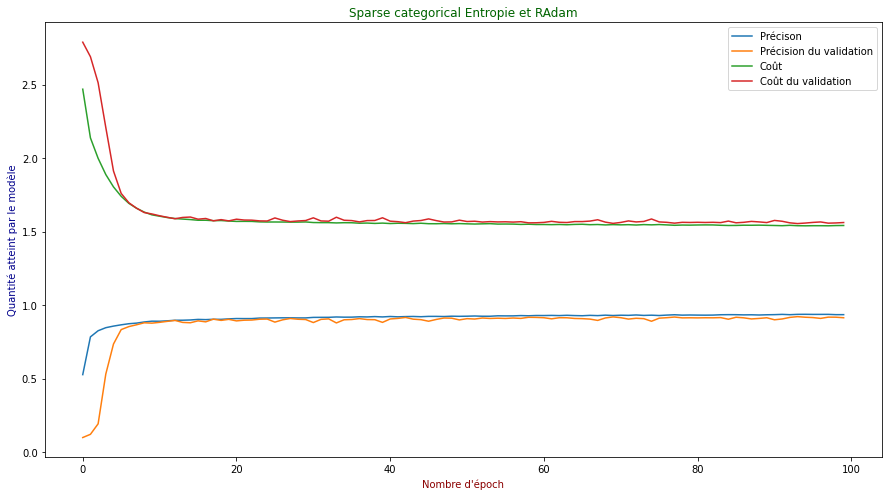

In [95]:
w=15
h=8
plt.figure(figsize=(w,h))
plt.plot(hist.history['accuracy'],label='Précison',)
plt.plot(hist.history['val_accuracy'],label='Précision du validation')

plt.plot(hist.history['loss'],label='Coût')
plt.plot(hist.history['val_loss'],label='Coût du validation')

plt.xlabel("Nombre d'époch",c='darkred')
plt.ylabel("Quantité atteint par le modèle",c='darkblue')
plt.title('Sparse categorical cross Entropie et RAdam',c='darkgreen')
plt.legend()
plt.show()



### **Evaluation (test) de notre modèle**

In [120]:
#Evaluate accuracy
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest de précision : {:.2f}% \nTest du loss      : {:.2f}%'.format(test_acc*100,test_loss*100))

266/266 - 1s - loss: 1.5623 - accuracy: 0.9145

Test de précision : 91.45% 
Test du loss      : 156.23%


[1.2670414e-19 1.5055669e-20 4.8808855e-16 5.3926789e-17 1.1431685e-16
 4.1941169e-20 1.5647239e-20 1.0000000e+00 7.9961886e-21 3.8679472e-19]


## **Fonction d'affichage des prédictions**

In [130]:
x_predict = x_predict.reshape(-1, 28,28,1)
classifications = model.predict(x_predict)
x_predict = x_predict.reshape(-1, 28,28)

index = 462
print(f'probabilité(logits) du {index}ème élément : \n{classifications[index]}') 

probabilité du 462ème élément : 
[9.5386235e-28 9.6713862e-32 1.0000000e+00 6.1675932e-31 6.1751816e-36
 6.4866396e-35 3.2674720e-31 4.3157992e-33 7.6746314e-33 4.5130707e-36]


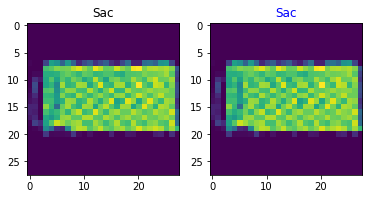

In [68]:
def plot_prediction(index_test, prediction_result):
  if type(index_test) is not int:
    raise ValueError(f"""Erreur '{index_test}' n'est pas un entier, Annulation...""")
  try:
    label = int(index_test)
    name = y_predict[label]
    
    classifications = prediction_result
    name_predicted  = classifications[label].argmax()
  except IndexError:
    raise


  global x_predict
  if x_predict.shape is 4:
    x_predict = x_predict.reshape(-1, 28,28)
  #Drawing the two images
  plt.figure(figsize=(6,6))

  #The image of test
  plt.subplot(1,2,1)
  plt.imshow(x_predict[label])
  plt.title(class_names_fr[name])

  #Predicted image
  plt.subplot(1,2,2)
  plt.imshow(x_predict[label])

  if class_names_fr[name_predicted] == class_names_fr[name]:
    plt.title(class_names_fr[name_predicted],c='blue')
  else:
    plt.title(class_names_fr[name_predicted],c='red')

  #Drawing in the subplot
  plt.show()


plot_prediction(196, classifications)

# **Sauvegarde du modèle et certains données de notre modèle**

*Cette section je l'ai pris sur* : 
https://www.tensorflow.org/guide/keras/save_and_serialize#whole-model_saving

## **Sauvegarde du modèle**


In [0]:
model.reset_metrics()
# Save the model
model.save('model_PFE_mnist',save_format='tf')

## **Lecture du modèle sauvegardée**

In [0]:
# Recreate the exact same model purely from the file
new_model = keras.models.load_model('model_PFE_mnist',custom_objects={'RAdam':RAdam})

## **Sauvegarde des données statistiques du modèle**

In [0]:
import pickle
with open('save.txt','wb') as save:
  pickle.dump(hist.history,save)

## **Lecture des données statistique qui sont serialisées**

In [0]:
new_hist = keras.callbacks.History()
with open ('save.txt','rb') as s:
  new_hist.history = pickle.load(s)

In [0]:
# Export the model to a SavedModel
model.save('path_to_saved_model', save_format='tf')

# Recreate the exact same model
new_model = keras.models.load_model('path_to_saved_model')

# Check that the state is preserved
new_predictions = new_model.predict(x_test)
np.testing.assert_allclose(predictions, new_predictions, rtol=1e-6, atol=1e-6)

# Note that the optimizer state is preserved as well:
# you can resume training where you left off.
